In [ ]:
# Install the Kaggle API package
!pip install kaggle


In [ ]:
# Create a folder for the Kaggle API key and move the kaggle.json file
import os
from google.colab import files

# Upload kaggle.json file
files.upload()

# Create directory for kaggle.json and move the uploaded file to this directory
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/

# Set permissions for the Kaggle JSON file
!chmod 600 /root/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
# Download the dataset from Kaggle
!kaggle datasets download -d sumn2u/garbage-classification-v2

# Unzip the dataset
!unzip garbage-classification-v2.zip -d garbage_data


Streaming output truncated to the last 5000 lines.
  inflating: garbage_data/garbage-dataset/paper/paper_847.jpg  
  inflating: garbage_data/garbage-dataset/paper/paper_848.jpg  
  inflating: garbage_data/garbage-dataset/paper/paper_849.jpg  
  inflating: garbage_data/garbage-dataset/paper/paper_851.jpg  
  inflating: garbage_data/garbage-dataset/paper/paper_852.jpg  
  inflating: garbage_data/garbage-dataset/paper/paper_853.jpg  
  inflating: garbage_data/garbage-dataset/paper/paper_855.jpg  
  inflating: garbage_data/garbage-dataset/paper/paper_856.jpg  
  inflating: garbage_data/garbage-dataset/paper/paper_857.jpg  
  inflating: garbage_data/garbage-dataset/paper/paper_859.jpg  
  inflating: garbage_data/garbage-dataset/paper/paper_861.jpg  
  inflating: garbage_data/garbage-dataset/paper/paper_863.jpg  
  inflating: garbage_data/garbage-dataset/paper/paper_865.jpg  
  inflating: garbage_data/garbage-dataset/paper/paper_868.jpg  
  inflating: garbage_data/garbage-dataset/paper/paper

In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error


In [ ]:
# Define the dataset directory
data_dir = 'garbage_data/garbage-dataset'

# List subdirectories (each representing a waste class)
categories = os.listdir(data_dir)
print("Waste Categories:", categories)


Waste Categories: ['glass', 'cardboard', 'metal', 'trash', 'clothes', 'shoes', 'paper', 'biological', 'battery', 'plastic']


In [ ]:
# Create a DataFrame for images and their labels
data = []
for category in categories:
    category_path = os.path.join(data_dir, category)
    for image_name in os.listdir(category_path):
        data.append((os.path.join(category_path, image_name), category))

# Convert to DataFrame
df = pd.DataFrame(data, columns=['Image', 'Label'])
print(df.head())


                                               Image  Label
0  garbage_data/garbage-dataset/glass/glass_2042.jpg  glass
1  garbage_data/garbage-dataset/glass/glass_2229.jpg  glass
2  garbage_data/garbage-dataset/glass/glass_4059.jpg  glass
3  garbage_data/garbage-dataset/glass/glass_3043.jpg  glass
4   garbage_data/garbage-dataset/glass/glass_909.jpg  glass


In [ ]:
# Image preprocessing using ImageDataGenerator
datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

# Train and validation generators
train_generator = datagen.flow_from_directory(
    data_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='training'
)
validation_generator = datagen.flow_from_directory(
    data_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='validation'
)


Found 15813 images belonging to 10 classes.
Found 3949 images belonging to 10 classes.


In [20]:
# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(categories), activation='softmax')  # Output layer for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_generator, validation_data=validation_generator, epochs=9)


Epoch 1/9
495/495 ━━━━━━━━━━━━━━━━━━━━ 53s 104ms/step - accuracy: 0.4274 - loss: 1.8920 - val_accuracy: 0.5738 - val_loss: 1.2520
Epoch 2/9
495/495 ━━━━━━━━━━━━━━━━━━━━ 81s 101ms/step - accuracy: 0.6590 - loss: 1.0032 - val_accuracy: 0.6460 - val_loss: 1.0674
Epoch 3/9
495/495 ━━━━━━━━━━━━━━━━━━━━ 81s 100ms/step - accuracy: 0.7818 - loss: 0.6595 - val_accuracy: 0.6678 - val_loss: 1.0236
Epoch 4/9
495/495 ━━━━━━━━━━━━━━━━━━━━ 82s 99ms/step - accuracy: 0.8810 - loss: 0.3692 - val_accuracy: 0.6938 - val_loss: 1.1333
Epoch 5/9
495/495 ━━━━━━━━━━━━━━━━━━━━ 50s 100ms/step - accuracy: 0.9374 - loss: 0.2025 - val_accuracy: 0.6802 - val_loss: 1.4172
Epoch 6/9
495/495 ━━━━━━━━━━━━━━━━━━━━ 50s 100ms/step - accuracy: 0.9636 - loss: 0.1270 - val_accuracy: 0.6860 - val_loss: 1.5608
Epoch 7/9
495/495 ━━━━━━━━━━━━━━━━━━━━ 81s 99ms/step - accuracy: 0.9696 - loss: 0.1007 - val_accuracy: 0.6673 - val_loss: 1.9311
Epoch 8/9
495/495 ━━━━━━━━━━━━━━━━━━━━ 83s 100ms/step - accuracy: 0.9783 - loss: 0.0729 - va

In [ ]:
# Simulate daily waste classification counts for each category
import random
from datetime import timedelta

# Create a synthetic time-series of daily waste predictions for 30 days
start_date = pd.to_datetime('2024-01-01')
daily_data = []
for i in range(30):
    date = start_date + timedelta(days=i)
    daily_counts = {category: random.randint(50, 200) for category in categories}
    daily_counts['Date'] = date
    daily_data.append(daily_counts)

# Convert to DataFrame
time_series_df = pd.DataFrame(daily_data)
time_series_df.set_index('Date', inplace=True)
print(time_series_df.head())


            glass  cardboard  metal  trash  clothes  shoes  paper  biological  \
Date                                                                            
2024-01-01     53         98    103    136      184    171    126         197   
2024-01-02    119         76     74    156      182    174     52         196   
2024-01-03    153        155    102    190       53     60     96          78   
2024-01-04    147         57    137    158      195     70    188         177   
2024-01-05    121        176    175     73      161    120    159         133   

            battery  plastic  
Date                          
2024-01-01      161      158  
2024-01-02      144      176  
2024-01-03      187       99  
2024-01-04      174      164  
2024-01-05      158      172  


In [ ]:
# Perform the Augmented Dickey-Fuller test (ADF) on plastic waste
result = adfuller(time_series_df['plastic'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: -2.1276502614928923
p-value: 0.2335426006478566


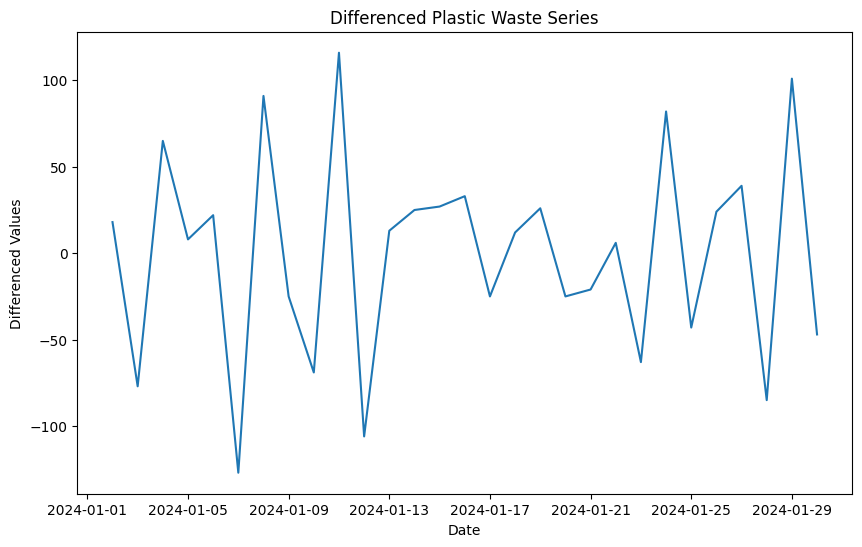

In [ ]:
# Differencing to make the series stationary (if needed)
time_series_df['Plastic_diff'] = time_series_df['plastic'].diff().dropna()

# Plot the differenced series
plt.figure(figsize=(10, 6))
plt.plot(time_series_df['Plastic_diff'])
plt.title("Differenced Plastic Waste Series")
plt.xlabel("Date")
plt.ylabel("Differenced Values")
plt.show()


In [ ]:
# Fit ARIMA model (parameters p, d, q determined manually or via grid search)
plastic_series = time_series_df['plastic']
model = ARIMA(plastic_series, order=(1, 1, 1))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                plastic   No. Observations:                   30
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -148.837
Date:                Thu, 26 Dec 2024   AIC                            303.674
Time:                        18:01:19   BIC                            307.776
Sample:                    01-01-2024   HQIC                           304.959
                         - 01-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1549      0.230     -0.674      0.500      -0.606       0.296
ma.L1         -0.9975      6.346     -0.157      0.875     -13.436      11.441
sigma2      1483.0341   9195.068      0.161      0.8

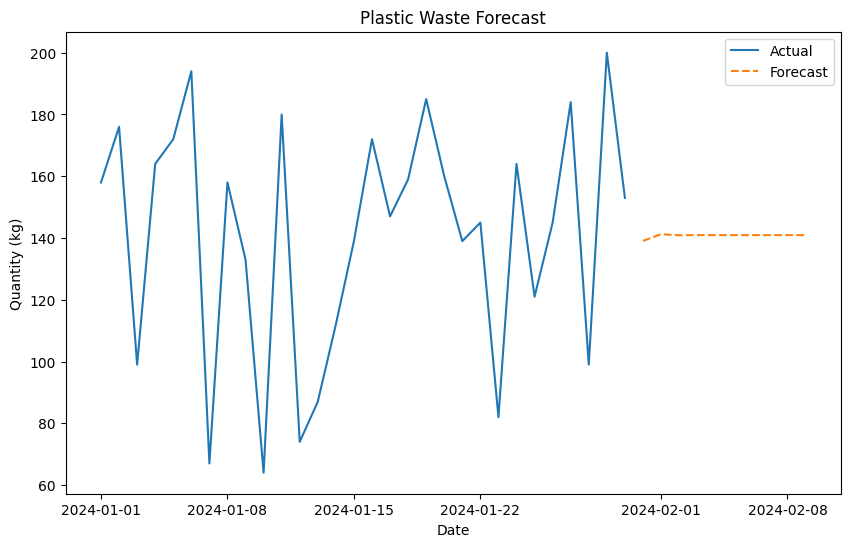

In [ ]:
# Forecast the next 10 days
forecast_steps = 10
forecast = model_fit.forecast(steps=forecast_steps)

# Create a DataFrame for forecasted values
forecast_dates = pd.date_range(plastic_series.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast (kg)': forecast})
forecast_df.set_index('Date', inplace=True)

# Plot actual vs forecasted values
plt.figure(figsize=(10, 6))
plt.plot(plastic_series, label='Actual')
plt.plot(forecast_df['Forecast (kg)'], label='Forecast', linestyle='--')
plt.title("Plastic Waste Forecast")
plt.xlabel("Date")
plt.ylabel("Quantity (kg)")
plt.legend()
plt.show()


RMSE: 36.25292279934974


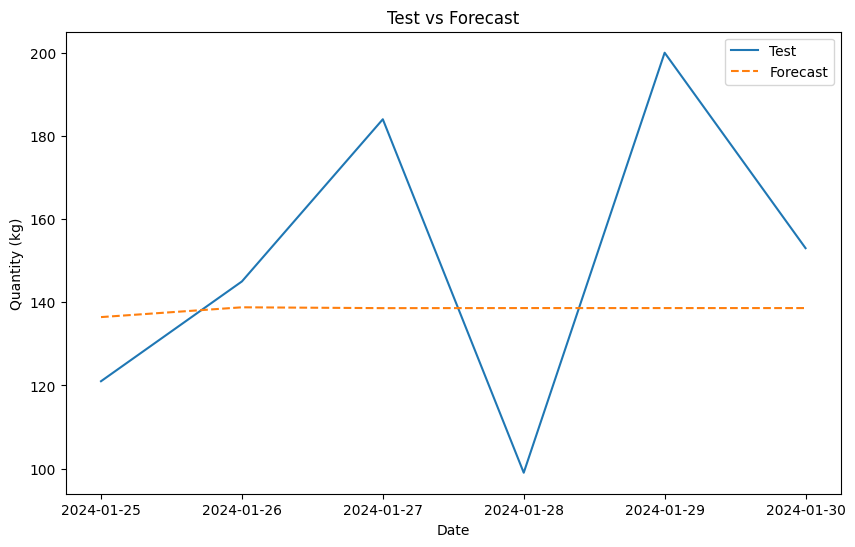

In [ ]:
# Ensure datetime index and set frequency
time_series_df.index = pd.to_datetime(time_series_df.index)  # Ensure datetime format
time_series_df = time_series_df.asfreq('D')  # Set frequency to daily

# Split data for evaluation (train-test split)
train_size = int(len(time_series_df) * 0.8)
train, test = time_series_df['plastic'][:train_size], time_series_df['plastic'][train_size:]

# Fit ARIMA model on training data
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Forecast test set
forecast_test = model_fit.forecast(steps=len(test))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, forecast_test))
print(f"RMSE: {rmse}")

# Plot test vs forecasted values
plt.figure(figsize=(10, 6))
plt.plot(test, label='Test')
plt.plot(forecast_test, label='Forecast', linestyle='--')
plt.title("Test vs Forecast")
plt.xlabel("Date")
plt.ylabel("Quantity (kg)")
plt.legend()
plt.show()




In [ ]:
# Save the ARIMA model for future use
import joblib

joblib.dump(model_fit, 'arima_plastic_model.pkl')
print("Model saved as arima_plastic_model.pkl")


Model saved as arima_plastic_model.pkl
